In [1]:
%%capture
from tqdm.notebook import tqdm
tqdm().pandas()
## This is for progress bars only ... not sure what `%%capture` does.

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
# from sklearn.neighbors import KernelDensity
import colorcet as cc # colortables
import palettable     # more colortables!
from scipy.ndimage import label, generate_binary_structure

In [3]:
import cartopy
import cartopy.crs as ccrs

In [4]:
def get_tropics_quantiles(da, threshold=None, q=0.99):
    da_tropics = da.sel(lat=slice(-30, 30))  # SHOULD BE ADJUSTABLE
    da_tropics_val = np.nanquantile(da_tropics, q)
    if threshold is not None:
        da_climo = da.mean(dim="time")
        da_process = np.where(
            (da_climo >= threshold).sel(lat=slice(-30, 30)).broadcast_like(da_tropics),
            da_tropics,
            np.nan,
        )
        da_threshold_val = np.nanquantile(da_process, q)
        print(
            f"Compare the tropics region ({da_tropics_val}) to the rainy tropics ({da_threshold_val})"
        )
        return da_threshold_val
    else:
        print(f"Quantile value: {da_tropics_val}")
        return da_tropics_val


def get_labels(da, crit):
    assert "time" in da.dims
    assert "lat" in da.dims
    assert "lon" in da.dims
    mask = np.where(da >= crit, 1, 0)
    assert len(mask.shape) == 3  # has to be time,lat,lon
    labeled_arrays = []
    n_features = []
    for t in range(mask.shape[0]):
        la, nf = label(mask[t, :, :], structure=generate_binary_structure(2, 2))
        la = xr.DataArray(
            la, dims=("lat", "lon"), coords={"lat": da.lat, "lon": da.lon}
        )
        labeled_arrays.append(la)
        n_features.append(nf)
    nfarr = xr.DataArray(np.array(n_features), dims="time", coords={"time": da.time})
    lbarr = xr.concat(labeled_arrays, dim="time")
    lbarr = lbarr.assign_coords({"time": da.time})
    return lbarr, nfarr


def get_labels3d(da, crit):
    """Label events through time."""
    assert "time" in da.dims
    assert "lat" in da.dims
    assert "lon" in da.dims
    mask = np.where(da >= crit, 1, 0)
    assert len(mask.shape) == 3  # has to be time,lat,lon
    la, nf = label(mask, structure=generate_binary_structure(3, 2))
    la = xr.DataArray(la, dims=da.dims, coords=da.coords)
    # nf is just an integer
    return la, nf


def pr_labeler(p, pcrit, track=False, latitude=None):
    """This method just controls the flow to the different labeling functions."""
    if latitude is not None:
        pw = p.sel(lat=latitude)
    else:
        pw = p
    if track:
        labels, nfeatures = get_labels3d(pw, pcrit)
    else:
        labels, nfeatures = get_labels(pw, pcrit)
    return labels, nfeatures


def get_events_per_time(larr):
    return [len(np.unique(larr[t,:,:]))-1 for t in range(larr.shape[0])]


def get_simple_size(larr):
    """larr is set of labeled arrays. 
    Count how many points have each label, 
    return average and standard deviation 
    of that count for each time."""
    a_size = []
    a_sizestd = []
    for i, tim in enumerate(larr["time"]):
        ctr = np.bincount(larr[i, :, :].values.flatten())
        a_size.append(ctr[1::].mean())
        a_sizestd.append(ctr[1::].std())
    a_size = np.array(a_size)
    a_sizestd = np.array(a_sizestd)
    return a_size, a_sizestd


def quick_load_var(loc, var, table, model, experiment, member):
    fils = sorted(
        list(Path(loc).glob("_".join([var, table, model, experiment, member, "*.nc"])))
    )
    if len(fils) == 0:
        raise IOError("Can not find the files.")
    elif len(fils) == 1:
        ds = xr.open_dataset(fils[0])
    else:
        ds = xr.open_mfdataset(fils, combine="by_coords")
    return ds[var].compute()

In [5]:
# We should account for wrapping around longitude
# * https://stackoverflow.com/questions/55953353/how-to-specify-a-periodic-connection-for-features-of-scipy-ndimage-label
# if this is fast enough, it will also provide a vector of features per time

# Performance notes:
# This is potentially very slow.
# Naive approach would loop over all times and all latitudes, which is already a bit slow.
# Pretty easy to reduce that by checking whether there are any values to check. 
# Even reducing the loops to what I think is minimal, it is slow if we 
# try to update the array with boolean indexing for each identified wrapped feature.
# For example, doing new_labels[new_labels == new_labels[t, y, 0]] = older_feature
# I'm not sure exactly why this is so slow.
# MUCH, MUCH faster is to make a list of changes that need to be made.
# Here, `transformer` is the list, just a dictionary with keys being the feature to change
# and values being the corrected value. Creating this dictionary is very fast.
# Then a separate step loops through the dictionary and actually does the change,
# for example using labels = np.where(labels==dictkey, dictvalue, labels)
# In my test case, my initial attempts were going to run for ~2.5 hours,
# but in the transformer/where steps, that was reduced to ~5 minutes.

def wrap_events(input_labels):
    if isinstance(input_labels, xr.DataArray):
        labels = input_labels.values
    else:
        labels = input_labels
    new_labels = labels.copy()
    transformer = dict()
    for t in tqdm(range(new_labels.shape[0])):
        if np.all(new_labels[t,:,0] == 0) or np.all(new_labels[t,:,-1] == 0):
            continue  # no reason to check if no events on edges
        check_lats = np.intersect1d(np.nonzero(new_labels[t, :, 0]), np.nonzero(new_labels[t, :, -1]))
        if len(check_lats) == 0:
            continue
        for y in check_lats:
            if new_labels[t,y,0] != new_labels[t,y,-1]:
                # now we know that [t, y, 0] and [t, y, -1] should be part of same feature, and the label should be the smaller of the two
                older_feature = np.min([new_labels[t, y, 0], new_labels[t, y, -1]])
                if new_labels[t, y, 0] < new_labels[t, y, -1]:
                    transformer[new_labels[t, y, -1]] = older_feature
                else:
                    transformer[new_labels[t, y, 0]] = older_feature
    return transformer


def event_wrapper(labels, transformer_dict):
    if isinstance(labels, xr.DataArray):
        lll = labels.values
    else:
        lll = labels
    new_labels = lll.copy()
    for k in tqdm(transformer_dict):
        new_labels = np.where(new_labels==k, transformer_dict[k], new_labels)
    if isinstance(labels, xr.DataArray):
        new_labels = xr.DataArray(new_labels, dims=labels.dims, coords=labels.coords)
    return new_labels


def get_initial_tindex(labels, ev):
    if isinstance(labels, np.ndarray):
        labv = labels
    else:
        labv = labels.values  # converts to numpy array
    for t in range(labv.shape[0]):
        tmp = labv[t,:,:] # temporary time slice
        present_events = set(tmp[tmp != 0]) # uniq events in this time
        if ev in present_events:
            return t
    return None




In [6]:
def pr_label_workflow(
    model,
    exp0,
    exp1,
    mem0,
    mem1,
    remove_land=False,
    label="2d",
    latitude=None,
    lon_wrap=True,
):
    """Loads daily precipitation data for 2 simulations, 
    calculates the 99th percentile of tropical precipitation,
    detects precipitation features.
    Options:
        - remove_land : loads land fraction for the simulation and removes land.
        - label : if '2d' do detection on time slices independently, 
                  if '3d' do detection in time (cheap tracking).
        - latitude : use a subset of latitudes, typically provide a slice object.
        - lon_wrap : if true run the code to connect events across longitude boundary.
        
    Commented out the `get_simple_size` lines... do those afterward.
    
    No longer return number of features. Depends on whether tracking or not, also changes
    if lon_wrap is True, so need to re-calculate either way. 
    """
    m0 = quick_load_var(data_loc, "pr", "day", model, exp0, mem0)
    m0 *= 86400.0  # unit conversion
    if remove_land:
        land0 = quick_load_var(data_loc, "sftlf", "fx", model, exp0, mem0)
        m0 = m0.where(land0 <= 0)
    m0_threshold = get_tropics_quantiles(m0, q=0.99)

    if label == "2d":
        track = False
    elif label == "3d":
        track = True

    m0_labels, m0_nfeatures = pr_labeler(
        m0, m0_threshold, track=track, latitude=latitude
    )

    m1 = quick_load_var(data_loc, "pr", "day", model, exp1, mem1)
    m1 *= 86400.0  # unit conversion
    if remove_land:
        land1 = quick_load_var(data_loc, "sftlf", "fx", model, exp1, mem1)
        m1 = m1.where(land1 <= 0)
    m1_threshold = get_tropics_quantiles(m1, q=0.99)
    m1_labels, m1_nfeatures = pr_labeler(
        m1, m1_threshold, track=track, latitude=latitude
    )

    if lon_wrap:
        m0_transformer = wrap_events(m0_labels)
        m1_transformer = wrap_events(m1_labels)
        m0_labels = event_wrapper(m0_labels, m0_transformer)
        m1_labels = event_wrapper(m1_labels, m1_transformer)

    # m0_size, m0_sizestd = get_simple_size(m0_labels)
    # m1_size, m1_sizestd = get_simple_size(m1_labels)
    return m0_labels, m1_labels

In [7]:
def cesm_rmland(d):
        land_f = xr.open_dataset("/Users/brianpm/Dropbox/Data/cesm2_f09_land.nc")
        landx = land_f['LANDFRAC'].squeeze()
        land0, _ = xr.broadcast(landx, d)
        return d.where(land0 <= 0)

def cesm_fix_timedim(ds):
    nt = ds['time_bnds'].mean(dim='nbnd')
    nt.attrs = ds['time'].attrs
    ds['time'] = nt
    return xr.decode_cf(ds)

In [8]:
def cesm_pr_label_workflow(
    pr0,
    pr1,
    remove_land=False,
    label="2d",
    latitude=None,
    lon_wrap=True,
):
    """Uses daily precipitation data for 2 simulations, 
    calculates the 99th percentile of tropical precipitation,
    detects precipitation features.
    Options:
        - remove_land : loads land fraction for the simulation and removes land.
        - label : if '2d' do detection on time slices independently, 
                  if '3d' do detection in time (cheap tracking).
        - latitude : use a subset of latitudes, typically provide a slice object.
        - lon_wrap : if true run the code to connect events across longitude boundary.
        
    Commented out the `get_simple_size` lines... do those afterward.
    
    No longer return number of features. Depends on whether tracking or not, also changes
    if lon_wrap is True, so need to re-calculate either way. 
    """
    if remove_land:
        print("REMOVE LAND")
        pr0 = cesm_rmland(pr0)
        pr1 = cesm_rmland(pr1)
        print(f"SHAPE OF MASKED: {pr0.shape}")
    m0_threshold = get_tropics_quantiles(pr0, q=0.99)
    m1_threshold = get_tropics_quantiles(pr1, q=0.99)
    
    if label == "2d":
        track = False
    elif label == "3d":
        track = True

    m0_labels, m0_nfeatures = pr_labeler(
        pr0, m0_threshold, track=track, latitude=latitude
    )


    m1_labels, m1_nfeatures = pr_labeler(
        pr1, m1_threshold, track=track, latitude=latitude
    )

    if lon_wrap:
        m0_transformer = wrap_events(m0_labels)
        m1_transformer = wrap_events(m1_labels)
        m0_labels = event_wrapper(m0_labels, m0_transformer)
        m1_labels = event_wrapper(m1_labels, m1_transformer)

    # m0_size, m0_sizestd = get_simple_size(m0_labels)
    # m1_size, m1_sizestd = get_simple_size(m1_labels)
    return m0_labels, m1_labels

In [9]:
def get_duration(lab):
    """Returns a dictionary with keys that are event labels and values that are duration (days)."""
    dur = dict()
    if isinstance(lab, np.ndarray):
        labv = lab
    else:
        labv = lab.values  # converts to numpy array
    for t in range(lab.shape[0]):
        tmp = labv[t,:,:] # temporary time slice
        present_events = set(tmp[tmp != 0]) # uniq events in this time
        if len(present_events) > 0:
            for ev in present_events:
                if ev in dur:
                    dur[ev] += 1 # continuing
                else:
                    dur[ev] = 1 # new event
    return dur

In [10]:
def get_duration_and_size(lab, rettype='df'):
    """Returns either a Pandas DataFrame (default) or dictionary with keys that are event labels and values that are duration (days)."""
    dur = dict()
    # put eventID as key, values are dict: {duration: D, size: [s_0, ..., s_d]}
    if isinstance(lab, np.ndarray):
        labv = lab
    else:
        labv = lab.values  # converts to numpy array
    for t in range(lab.shape[0]):
        tmp = labv[t,:,:] # temporary time slice
        present_events = set(tmp[tmp != 0]) # uniq events in this time
        if len(present_events) > 0:
            for ev in present_events:
                if ev in dur:
                    dur[ev]['duration'] += 1 # continuing
                    dur[ev]['size'].append(np.count_nonzero(tmp==ev))
                else:
                    dur[ev] = dict() # new event
                    dur[ev]['duration'] = 1
                    dur[ev]['size'] = [np.count_nonzero(tmp==ev)]
    if rettype == 'df':
        # convert to dataFrame
        df = pd.DataFrame.from_dict(dur, orient ='index')
        # compute average size and include as a column
        asiz = []
        msiz = []
        for s in df['size']:
            asiz.append(np.mean(s))
            msiz.append(np.max(s))
        df['AvgSiz'] = asiz
        df['MaxSiz'] = msiz
        # get distribution of average size
        return df
    else:
        return dur  # AvgSiz and MaxSiz not included in output dict.

In [11]:
def summarize_events(labels, mstr, estr):
    X = get_events_per_time(labels)
    Y = get_duration_and_size(labels)  # Y is a pandas DF with columns: duration, size, AvgSiz, MaxSiz
    tot_number_events = len(Y)
#     dur = []
#     avgsiz = []
#     mxsiz = []
#     for ev in Y:
#         dur.append(Y[ev]["duration"])
#         avgsiz.append(np.mean(Y[ev]["size"]))
#         mxsiz.append(np.max(Y[ev]["size"]))
    avg_duration = np.mean(Y['duration'])
    std_duration = np.std(Y['duration'])
    avg_size = np.mean(Y['AvgSiz'])
    std_size = np.std(Y['AvgSiz'])
    avg_mx_size = np.mean(Y['MaxSiz'])
    std_mx_size = np.std(Y['MaxSiz'])
    print(
        f"{mstr} {estr}: [N_events] = {np.mean(X):.2f} ± {np.std(X):.2f}, Ntot: {tot_number_events:.2f}, [D] = {avg_duration:.2f} ± {std_duration:.2f}, [S] = {avg_size:.2f} ± {std_size:.2f}, [Smx] = {avg_mx_size:.2f} ± {std_mx_size:.2f}"
    )

## Data Loading

We go and get the data from the external drive.

Note that CESM has it's timestamps in a confusing way, so we make the correction to mid-day values.

In [12]:
## LOCKING RUNS ARE NOT IN CMIP FORMAT

flock = xr.open_dataset('/Volumes/Samsung_T5/F1850JJB_c201_CLOCK.cam.h2.ncrcat.PRECT.nc')
flock = cesm_fix_timedim(flock)
fc = xr.open_dataset('/Volumes/Samsung_T5/F1850JJB_c201_CTL.cam.h2.ncrcat.PRECT.nc')
fc = cesm_fix_timedim(fc)
p_cntl = fc['PRECT']*86400.*1000.  # m/s -> mm/day
p_lock = flock['PRECT']*86400.*1000.

In [13]:
## Coupled runs
clock = xr.open_dataset('/Volumes/Samsung_T5/B1850_c201_CLOCK/daily/B1850_c201_CLOCK.cam.h2.ncrcat.PRECT.nc')
clock = cesm_fix_timedim(clock)
cc = xr.open_dataset('/Volumes/Samsung_T5/B1850_c201_CTL/daily/B1850_c201_CTL.cam.h2.ncrcat.PRECT.nc')
cc = cesm_fix_timedim(cc)
p_cc = cc['PRECT']*86400.*1000.  # m/s -> mm/day
p_clock = clock['PRECT']*86400.*1000.

## Event detection & tracking

For each of our 4 simulations, we take the daily average precipitation and label events that are heavily precipitating.

The analysis is restricted to the tropical oceans. Events only encompass points that have precipitation greater than the 99th percentile.

Summary statistics are presented immediately after the detection step. 

TO DO: Save the labeled data.

In [14]:
%%time
cntl_labels, lock_labels = cesm_pr_label_workflow(
    p_cntl,
    p_lock,
    remove_land=True,
    label="3d",
    latitude=slice(-30,30),
    lon_wrap=True,
)
summarize_events(cntl_labels, "CESM2", "F-control")
summarize_events(lock_labels, "CESM2", "F-lock")

REMOVE LAND
SHAPE OF MASKED: (9126, 192, 288)
Quantile value: 38.713140525817664
Quantile value: 35.38161060333249



CESM2 F-control: [N_events] = 12.74 ± 3.15, Ntot: 60224.00, [D] = 1.93 ± 2.21, [S] = 5.62 ± 6.39, [Smx] = 7.88 ± 11.75
CESM2 F-lock: [N_events] = 12.53 ± 3.25, Ntot: 61256.00, [D] = 1.87 ± 1.99, [S] = 5.96 ± 6.82, [Smx] = 8.36 ± 12.41
CPU times: user 50.8 s, sys: 18.9 s, total: 1min 9s
Wall time: 1min 10s


In [15]:
%%time
bc_labels, clock_labels = cesm_pr_label_workflow(
    p_cc,
    p_clock,
    remove_land=True,
    label="3d",
    latitude=slice(-30,30),
    lon_wrap=True,
)
summarize_events(bc_labels, "CESM2", "C-control")
summarize_events(clock_labels, "CESM2", "C-lock")  # "C" stands for coupled

REMOVE LAND
SHAPE OF MASKED: (10982, 192, 288)
Quantile value: 38.21372985839844
Quantile value: 36.03620056152363



CESM2 C-control: [N_events] = 13.12 ± 3.20, Ntot: 75500.00, [D] = 1.91 ± 2.06, [S] = 5.60 ± 6.38, [Smx] = 7.86 ± 11.73
CESM2 C-lock: [N_events] = 12.36 ± 3.26, Ntot: 62932.00, [D] = 1.86 ± 2.02, [S] = 5.93 ± 6.89, [Smx] = 8.33 ± 12.56
CPU times: user 58 s, sys: 24.7 s, total: 1min 22s
Wall time: 1min 24s


In [17]:
#
# Save labeled events so as to enable easier filtering
#
cntl_labels.name = "precip_events"
lock_labels.name = "precip_events"
bc_labels.name = "precip_events"
clock_labels.name = "precip_events"
outloc = Path("/Volumes/Glyph6TB/cloud_locking/pr_events/")

if 'type' in cntl_labels.coords:
    if cntl_labels['type'].shape == ():
        cntl_labels = cntl_labels.drop('type')
        
if 'type' in lock_labels.coords:
    if lock_labels['type'].shape == ():
        lock_labels = lock_labels.drop('type')

if 'type' in bc_labels.coords:
    if bc_labels['type'].shape == ():
        bc_labels = bc_labels.drop('type')
        
if 'type' in clock_labels.coords:
    if clock_labels['type'].shape == ():
        clock_labels = clock_labels.drop('type')

# Order doesn't matter here
# F-case LOCKED
oname0 = outloc / "pr_events_F1850JJB_c201_CLOCK.nc"
lock_labels.to_netcdf(oname0)

# F-case CONTROL
oname1 = outloc / "pr_events_F1850JJB_c201_CTL.nc"
cntl_labels.to_netcdf(oname1)

# B-case LOCKED
oname2 = outloc / "pr_events_B1850_c201_CLOCK.nc"
clock_labels.to_netcdf(oname2)

# B-case CONTROL
oname3 = outloc / "pr_events_B1850_c201_CTL.nc"
bc_labels.to_netcdf(oname3)




## Additional Analysis

Here we take a look at the spatial distribution of events. We simply count the number of events at each point in each simulation and normalize by the number of years in each record.

CPU times: user 541 ms, sys: 393 ms, total: 934 ms
Wall time: 935 ms


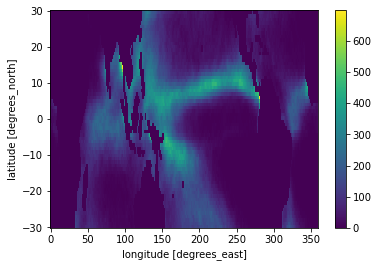

In [119]:
%%time
cntl_labels_spatial_tot = np.where(cntl_labels>0,1,0).sum(axis=0)
cntl_labels_spatial_tot = xr.DataArray(cntl_labels_spatial_tot, dims=("lat","lon"), coords={"lat":cntl_labels['lat'], "lon":cntl_labels['lon']})
cntl_labels_spatial_tot.plot.pcolormesh()

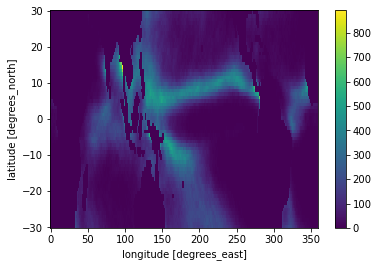

In [120]:
lock_labels_spatial_tot = np.where(lock_labels>0,1,0).sum(axis=0)
lock_labels_spatial_tot = xr.DataArray(lock_labels_spatial_tot, dims=("lat","lon"), coords={"lat":lock_labels['lat'], "lon":lock_labels['lon']})
lock_labels_spatial_tot.plot.pcolormesh()

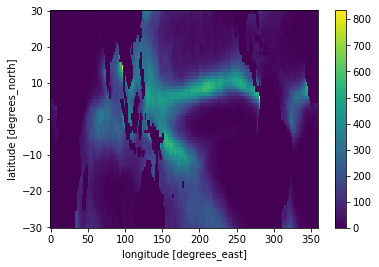

In [118]:
bc_labels_spatial_tot = np.where(bc_labels>0,1,0).sum(axis=0)
bc_labels_spatial_tot = xr.DataArray(bc_labels_spatial_tot, dims=("lat","lon"), coords={"lat":bc_labels['lat'], "lon":bc_labels['lon']})
bc_labels_spatial_tot.plot.pcolormesh()

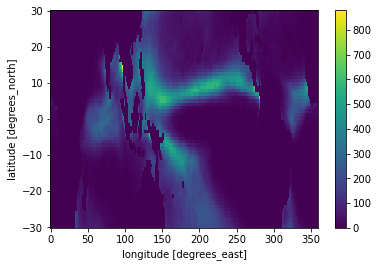

In [121]:
clock_labels_spatial_tot = np.where(clock_labels>0,1,0).sum(axis=0)
clock_labels_spatial_tot = xr.DataArray(clock_labels_spatial_tot, dims=("lat","lon"), coords={"lat":clock_labels['lat'], "lon":clock_labels['lon']})
clock_labels_spatial_tot.plot.pcolormesh()

In [122]:
# normalize by number of years:
cntl_frq = cntl_labels_spatial_tot/get_simulation_nyears(cntl_labels)
lock_frq = lock_labels_spatial_tot/get_simulation_nyears(lock_labels)
d_frq = lock_frq - cntl_frq

bc_frq = bc_labels_spatial_tot / get_simulation_nyears(bc_labels)
clock_frq = clock_labels_spatial_tot/get_simulation_nyears(clock_labels)
dc_frq = clock_frq - bc_frq
print(dc_frq)

<xarray.DataArray (lat: 64, lon: 288)>
array([[ 0.03846154,  0.03846154,  0.03846154, ...,  0.01240695,
         0.04466501,  0.00620347],
       [ 0.        ,  0.        ,  0.        , ..., -0.03225806,
         0.00620347, -0.03225806],
       [ 0.        ,  0.        ,  0.        , ..., -0.03225806,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
  * lat      (lat) float64 -29.69 -28.74 -27.8 -26.86 ... 26.86 27.8 28.74 29.69
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8


In [100]:
def get_simulation_nyears(ds):
    return len(set(ds['time.year'].values))

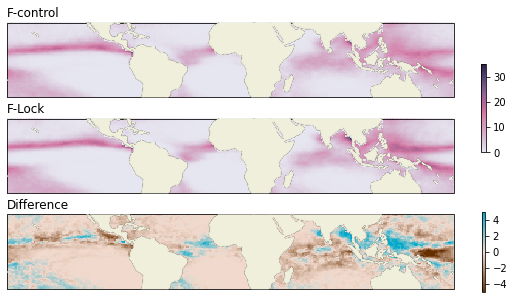

In [125]:

cm = palettable.scientific.sequential.Acton_20_r.mpl_colormap
lons, lats = np.meshgrid(cntl_labels_spatial_tot['lon'], cntl_labels_spatial_tot['lat'])
fig, ax = plt.subplots(figsize=(10,5), nrows=3, subplot_kw={"projection":ccrs.PlateCarree()})
img0 = ax[0].pcolormesh(lons, lats, cntl_frq, transform=ccrs.PlateCarree(), cmap=cm, vmin=0, vmax=35, rasterized=True)
img1 = ax[1].pcolormesh(lons, lats, lock_frq, transform=ccrs.PlateCarree(), cmap=cm, vmin=0, vmax=35, rasterized=True)
ax[0].coastlines()
ax[1].coastlines()
n = mpl.colors.TwoSlopeNorm(vmin=-5, vcenter=0, vmax=5)
cmdif =  palettable.lightbartlein.diverging.BrownBlue10_3.mpl_colormap
img2 = ax[2].pcolormesh(lons, lats, d_frq, transform=ccrs.PlateCarree(), cmap=cmdif, norm=n, rasterized=True)
ax[2].coastlines()
ax[0].add_feature(cartopy.feature.LAND, zorder=10)
ax[1].add_feature(cartopy.feature.LAND, zorder=10)
ax[2].add_feature(cartopy.feature.LAND, zorder=10)
# fig.suptitle("Number of events per year")
cb0 = fig.colorbar(img1, ax=ax[[0,1]].ravel(), shrink=0.5)
cb = fig.colorbar(img2, ax=ax[2])

ax[0].set_title("F-control", loc='left')
ax[1].set_title("F-Lock", loc='left')
ax[2].set_title("Difference", loc='left')
fig.savefig("/Users/brianpm/Desktop/cesm_fcase_pr_events.png", dpi=300, bbox_inches='tight')

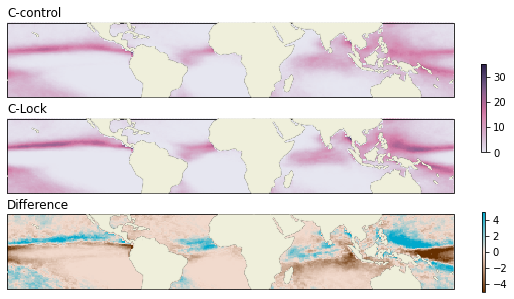

In [126]:
cm = palettable.scientific.sequential.Acton_20_r.mpl_colormap
# lons, lats = np.meshgrid(cntl_labels_spatial_tot['lon'], cntl_labels_spatial_tot['lat'])
fig, ax = plt.subplots(figsize=(10,5), nrows=3, subplot_kw={"projection":ccrs.PlateCarree()})
img0 = ax[0].pcolormesh(lons, lats, bc_frq, transform=ccrs.PlateCarree(), cmap=cm, vmin=0, vmax=35, rasterized=True)
img1 = ax[1].pcolormesh(lons, lats, clock_frq, transform=ccrs.PlateCarree(), cmap=cm, vmin=0, vmax=35, rasterized=True)
ax[0].coastlines()
ax[1].coastlines()
n = mpl.colors.TwoSlopeNorm(vmin=-5, vcenter=0, vmax=5)
cmdif =  palettable.lightbartlein.diverging.BrownBlue10_3.mpl_colormap
img2 = ax[2].pcolormesh(lons, lats, dc_frq, transform=ccrs.PlateCarree(), cmap=cmdif, norm=n, rasterized=True)
ax[2].coastlines()
ax[0].add_feature(cartopy.feature.LAND, zorder=10)
ax[1].add_feature(cartopy.feature.LAND, zorder=10)
ax[2].add_feature(cartopy.feature.LAND, zorder=10)
# fig.suptitle("Number of events per year")
cb0 = fig.colorbar(img1, ax=ax[[0,1]].ravel(), shrink=0.5)
cb = fig.colorbar(img2, ax=ax[2])

ax[0].set_title("C-control", loc='left')
ax[1].set_title("C-Lock", loc='left')
ax[2].set_title("Difference", loc='left')
fig.savefig("/Users/brianpm/Desktop/cesm_ccase_pr_events.png", dpi=300, bbox_inches='tight')

In [135]:
%%time

# precipitation, labels
# p_cntl, cntl_labels
# p_lock, lock_labels
# p_cc,  bc_labels
# p_clock, clock_labels
#
# -- histogram of precipitation -- 

pr1 = p_cntl
pr2 = p_lock
pr0_labels = cntl_labels
pr1_labels = lock_labels
rmlnd = True

if rmlnd:
    pr1 = cesm_rmland(pr1)
    pr2 = cesm_rmland(pr2)
# only tropics:
pr1 = pr1.sel(lat=slice(-30,30))
hpr1, hpredge1 = np.histogram(pr1.values, bins=np.arange(-10., 210., 10), density=True)
hpr1ctr = hpredge1[1:] + np.diff(hpredge1)
hpr1frq = hpr1*np.diff(hpredge1)

pr2 = pr2.sel(lat=slice(-30,30))
hpr2, hpredge2 = np.histogram(pr2.values, bins=np.arange(-10., 210., 10), density=True)
hpr2ctr = hpredge2[1:] + np.diff(hpredge2)
hpr2frq = hpr2*np.diff(hpredge2)

# -- duration and size -- 
dursiz0 = get_duration_and_size(pr0_labels)
dursiz1 = get_duration_and_size(pr1_labels)


hsiz0, sizedge0 = np.histogram(dursiz0['AvgSiz'], bins=np.arange(0, 50, 1), density=True)
sizbctr0 = sizedge0[1:] + np.diff(sizedge0)
hsizfrq0 = hsiz0 * np.diff(sizedge0)

hsiz1, sizedge1 = np.histogram(dursiz1['AvgSiz'], bins=np.arange(0, 50, 1), density=True)
sizbctr1 = sizedge1[1:] + np.diff(sizedge1)
hsizfrq1 = hsiz1 * np.diff(sizedge1)

# -- event duration --
hdur0, duredge0 = np.histogram(dursiz0['duration'], bins=np.arange(.5, 50.5, 1), density=True)
durfrq0 = hdur0 * np.diff(duredge0)
durctr0 = duredge0[1:] + np.diff(duredge0)

hdur1, duredge1 = np.histogram(dursiz1['duration'], bins=np.arange(.5, 50.5, 1), density=True)
durfrq1 = hdur1 * np.diff(duredge1)
durctr1 = duredge1[1:] + np.diff(duredge1)


CPU times: user 25.8 s, sys: 4.18 s, total: 30 s
Wall time: 30.1 s


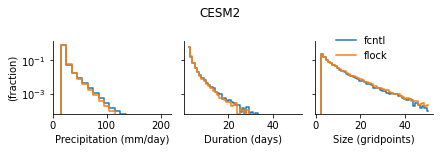

In [136]:
mdl1 = "CESM2"
e1 = "fcntl"
e2 = "flock"

fig, ax = plt.subplots(figsize=(6,2), ncols=3, constrained_layout=True, sharey=True)
ax[0].step(hpr1ctr, hpr1frq, where='mid')
ax[0].step(hpr2ctr, hpr2frq, where='mid')
ax[0].set_xlabel("Precipitation (mm/day)")
ax[0].set_ylabel("(fraction)")

ax[2].step(sizbctr0, hsizfrq0, where='mid', label=e1)
ax[2].step(sizbctr1, hsizfrq1, where='mid', label=e2)
ax[2].set_xlabel("Size (gridpoints)")

ax[1].step(durctr0, durfrq0, where='mid', label=e1)
ax[1].step(durctr1, durfrq1, where='mid', label=e2)
ax[1].set_xlabel("Duration (days)")

for a in ax:
    a.semilogy()
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.patch.set_alpha(0.)

ax[2].legend(frameon=False, loc='upper left', bbox_to_anchor= (.1, 1.2),)
fig.suptitle(mdl1)
fig.savefig(f"/Users/brianpm/Desktop/tropical_ocean_extreme_precip_distribution_{mdl1}_{e1}_{e2}.png", dpi=300, bbox_inches='tight')

In [137]:
# Alternative question is how much of the rain is associated with strong events?
pr1_crit = get_tropics_quantiles(pr1, threshold=None, q=0.99)
pr2_crit = get_tropics_quantiles(pr2, q=0.99)

pr1_tot = pr1.sum(dim=("lat","lon"))
pr1_xsum = pr1.where(pr1 >= pr1_crit).sum(dim=("lat","lon"))
pr1_xcontrib = pr1_xsum / pr1_tot

pr2_tot = pr2.sum(dim=("lat","lon"))
pr2_xsum = pr2.where(pr2 >= pr2_crit).sum(dim=("lat","lon"))
pr2_xcontrib = pr2_xsum / pr2_tot

print(f"Average extreme contribution in control: {pr1_xcontrib.values.mean():.2f} \pm {pr1_xcontrib.values.std():.2f}, and in LWoff: {pr2_xcontrib.values.mean():.2f} \pm {pr2_xcontrib.values.std():.2f}")

Quantile value: 38.713140525817664
Quantile value: 35.38161060333249
Average extreme contribution in control: 0.15 \pm 0.05, and in LWoff: 0.14 \pm 0.05
